In [1]:
# This code is based on: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = True

In [3]:
if using_colab:
  !unzip results.zip

Archive:  results.zip
   creating: results/
   creating: results/leopard2/
  inflating: results/leopard2/leopard2_gradcam_desc_1.jpg  
  inflating: results/leopard2/leopard2_gradcam_desc_2.jpg  
  inflating: results/leopard2/leopard2_superimposed_desc_2.jpg  
  inflating: results/leopard2/g_leopard2_gradcam_desc_1.jpg  
  inflating: results/leopard2/leopard2_superimposed_desc_0.jpg  
  inflating: results/leopard2/leopard2_input.jpg  
  inflating: results/leopard2/g_leopard2_gradcam_desc_0.jpg  
  inflating: results/leopard2/leopard2_superimposed_desc_1.jpg  
  inflating: results/leopard2/g_leopard2_gradcam_desc_2.jpg  
  inflating: results/leopard2/leopard2_gradcam_desc_0.jpg  
   creating: results/waterbird3/
  inflating: results/waterbird3/g_waterbird3_gradcam_desc_0.jpg  
  inflating: results/waterbird3/waterbird3_gradcam_desc_2.jpg  
  inflating: results/waterbird3/waterbird3_gradcam_desc_0.jpg  
  inflating: results/waterbird3/waterbird3_superimposed_desc_0.jpg  
  inflating: resu

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ahibhatq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ahibhatq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=39a4acc0fc3ed3173456ff20a1a7c006e7a2f165b338b4bc21b7d0799f276462
  Stored in directory: /tmp/pip-ephem-wheel-cache-21ypdt8j/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-08-03 18:18:58--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

In [5]:
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [7]:
def get_mask(input_path):

  image = cv2.imread(input_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.show()

  plt.figure()

  masks = mask_generator.generate(image)

  fig = plt.figure(figsize=(20., 20.))
  grid = ImageGrid(fig, 111,
                  nrows_ncols=(int((len(masks)+9)/10), 10),
                  axes_pad=0.1,
                  )

  l = []
  for i in range(len(masks)):
    l.append(masks[i]['segmentation'])

  for ax, im in zip(grid, l):
      ax.imshow(im)

  return masks

In [8]:
def compute_core_spurious(mask_nb, heatmap_paths, masks, custom_mask = None):
  if custom_mask is None:
    for i, heatmap in enumerate(heatmap_paths):
      K = torch.tensor(masks[mask_nb]['segmentation'])
      img = cv2.imread(heatmap, cv2.IMREAD_GRAYSCALE)
      img = (img - img.min()) / (img.max() - img.min())
      core_mean = img[K].mean()
      K = ~K
      spurious_mean = img[K].mean()
      print('Core %     description_{}:'.format(i), core_mean/(core_mean+spurious_mean))
      print('Spurious % description_{}:'.format(i), spurious_mean/(core_mean+spurious_mean))
  elif custom_mask == 'waterbird3':
    for i, heatmap in enumerate(heatmap_paths):
      K = np.logical_or(np.logical_or(masks[0]['segmentation'], masks[2]['segmentation']), np.logical_or(masks[5]['segmentation'], masks[11]['segmentation']))
      K[25:50, :] = True
      K = np.logical_or(K, masks[16]['segmentation'])
      K = np.logical_or(K, masks[15]['segmentation'])
      K = np.logical_or(K, masks[14]['segmentation'])
      K = np.logical_or(K, masks[12]['segmentation'])
      K = np.logical_or(K, masks[11]['segmentation'])
      K = np.logical_or(K, masks[9]['segmentation'])
      K = np.logical_or(K, masks[8]['segmentation'])
      K[70:85, :21] = True
      K[79:81, 20:22] = True
      K[73:79, 55:67] = True
      K[79:80, 57:67] = True
      K[90:110, :13] = True
      K[94:96, :14] = True
      K[96, :14] = True
      K[125:140, :52] = True
      K[115:120, :19] = True
      K[115:125, 30:50] = True
      K[115:125, 28:30] = True
      K[120:125, 26:30] = True
      K[122:125, 24:30] = True
      K[121:125, 25:30] = True
      K[120:140, 40:55] = True
      K[122:140, 40:56] = True
      K[123:140, 40:56] = True
      K[125:140, 40:57] = True
      K[127:140, 40:58] = True
      K[128:140, 40:59] = True
      K[130:140, 40:60] = True
      K = ~K
      plt.title('New mask')
      plt.imshow(K)
      img = cv2.imread(heatmap, cv2.IMREAD_GRAYSCALE)
      img = (img - img.min()) / (img.max() - img.min())
      core_mean = img[K].mean()
      K = ~K
      spurious_mean = img[K].mean()
      print('Core %     description_{}:'.format(i), core_mean/(core_mean+spurious_mean))
      print('Spurious % description_{}:'.format(i), spurious_mean/(core_mean+spurious_mean))

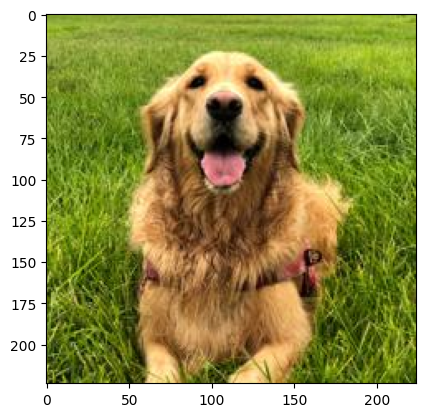

<Figure size 640x480 with 0 Axes>

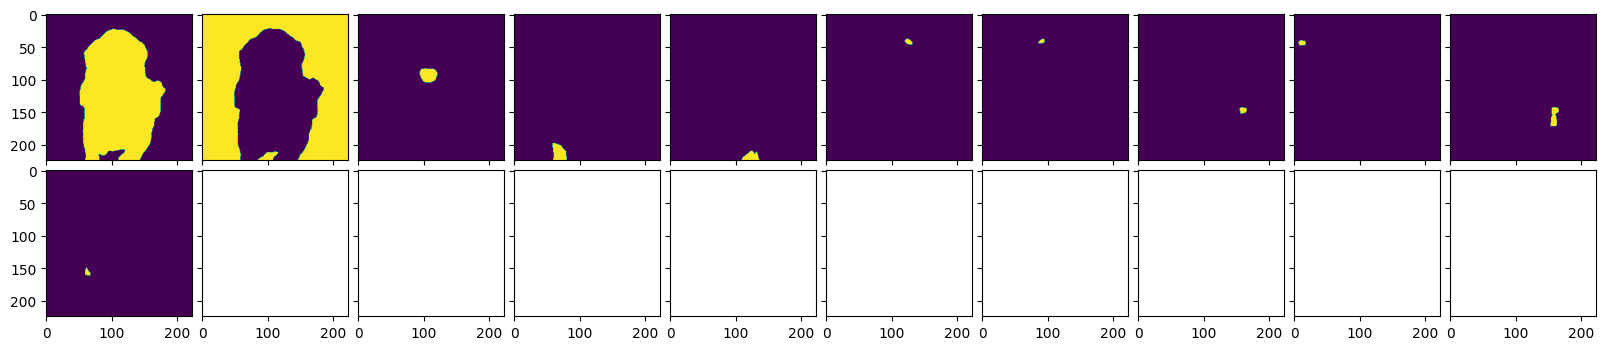

In [9]:
input_path = './results/golden_retriever/golden_retriever_input.jpg'
save_masks = get_mask(input_path)

In [10]:
mask_nb = 0
total_gradcams = 2
list_of_gradcams = []
for i in range(total_gradcams):
  list_of_gradcams.append('/'.join(input_path.split('/')[:-1]) + '/' + 'g_' + '_'.join(input_path.split('/')[-1].split('_')[:-1]) + '_gradcam_desc_{}.jpg'.format(i))
compute_core_spurious(mask_nb, list_of_gradcams, save_masks)

Core %     description_0: 0.6978783322881964
Spurious % description_0: 0.30212166771180365
Core %     description_1: 0.770941934963176
Spurious % description_1: 0.229058065036824


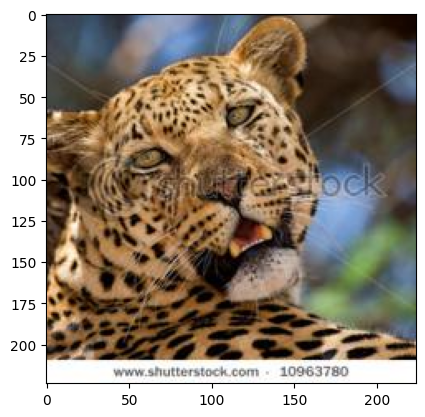

<Figure size 640x480 with 0 Axes>

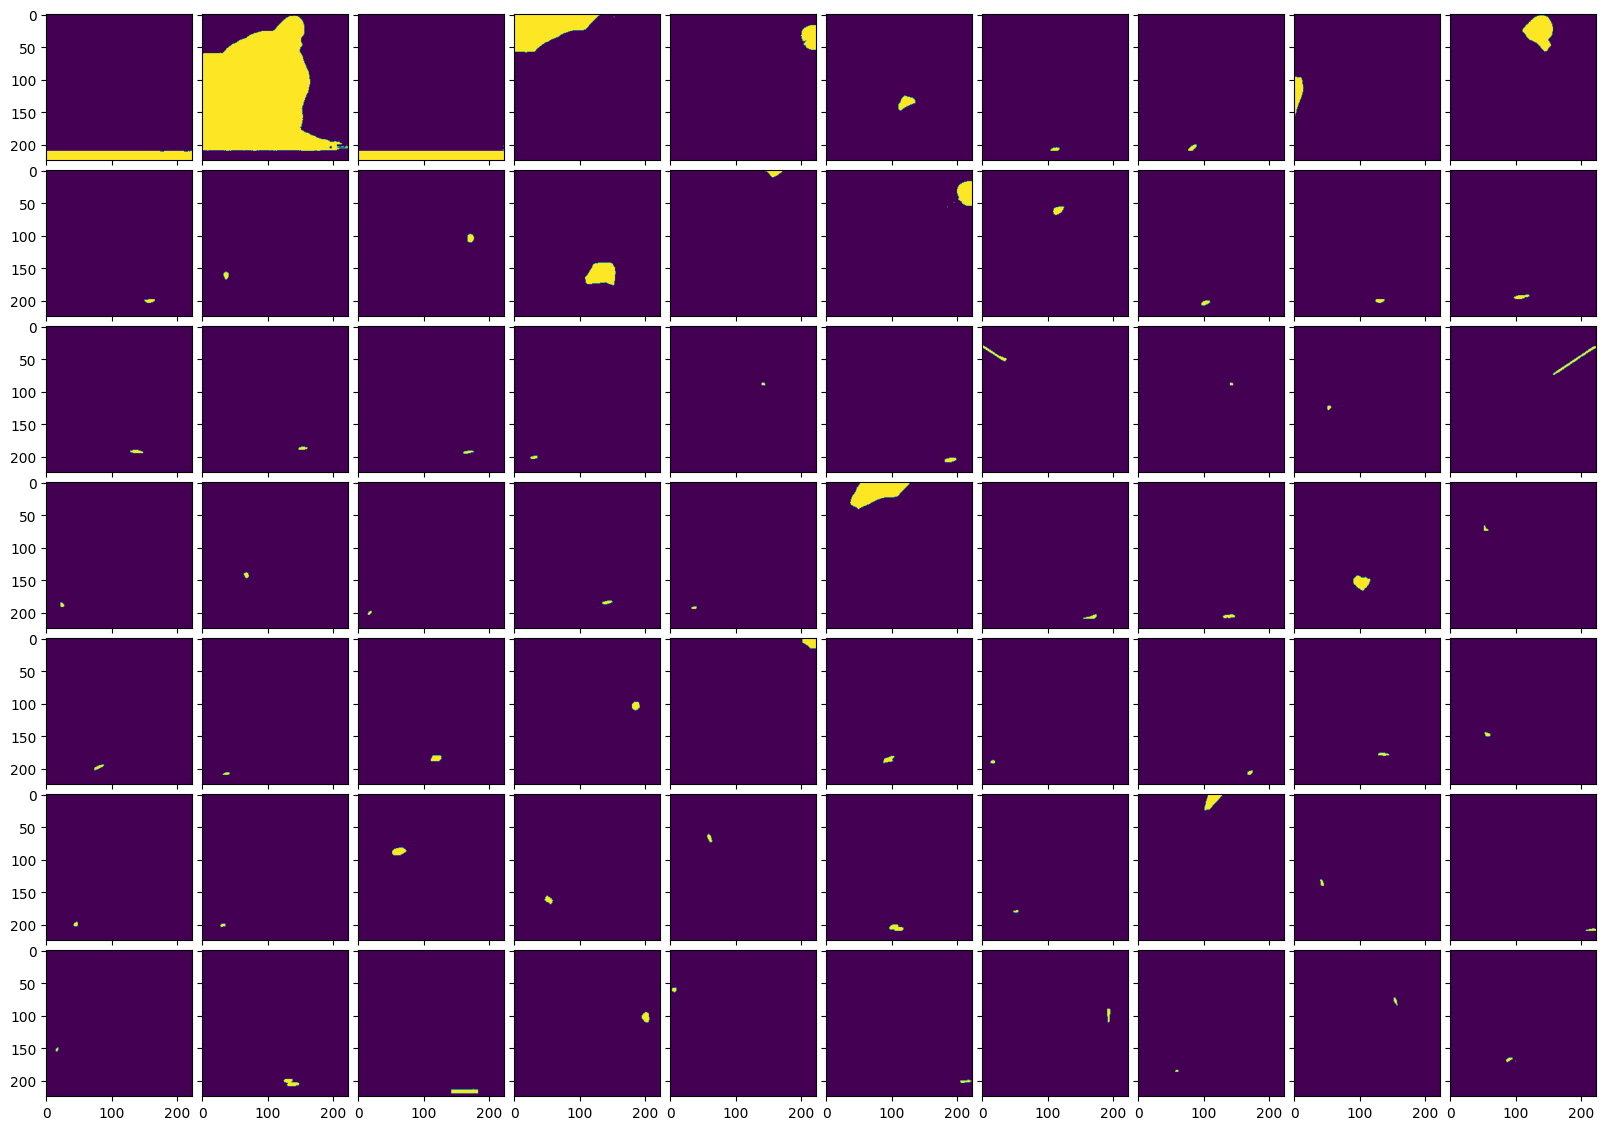

In [11]:
input_path = './results/leopard1/leopard1_input.jpg'
save_masks = get_mask(input_path)

In [12]:
mask_nb = 1
total_gradcams = 3
list_of_gradcams = []
for i in range(total_gradcams):
  list_of_gradcams.append('/'.join(input_path.split('/')[:-1]) + '/' + 'g_' + '_'.join(input_path.split('/')[-1].split('_')[:-1]) + '_gradcam_desc_{}.jpg'.format(i))
compute_core_spurious(mask_nb, list_of_gradcams, save_masks)

Core %     description_0: 0.4179907543108754
Spurious % description_0: 0.5820092456891246
Core %     description_1: 0.42435484644416677
Spurious % description_1: 0.5756451535558333
Core %     description_2: 0.5574392464689568
Spurious % description_2: 0.4425607535310431


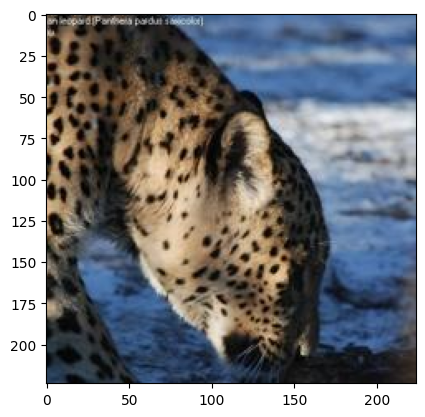

<Figure size 640x480 with 0 Axes>

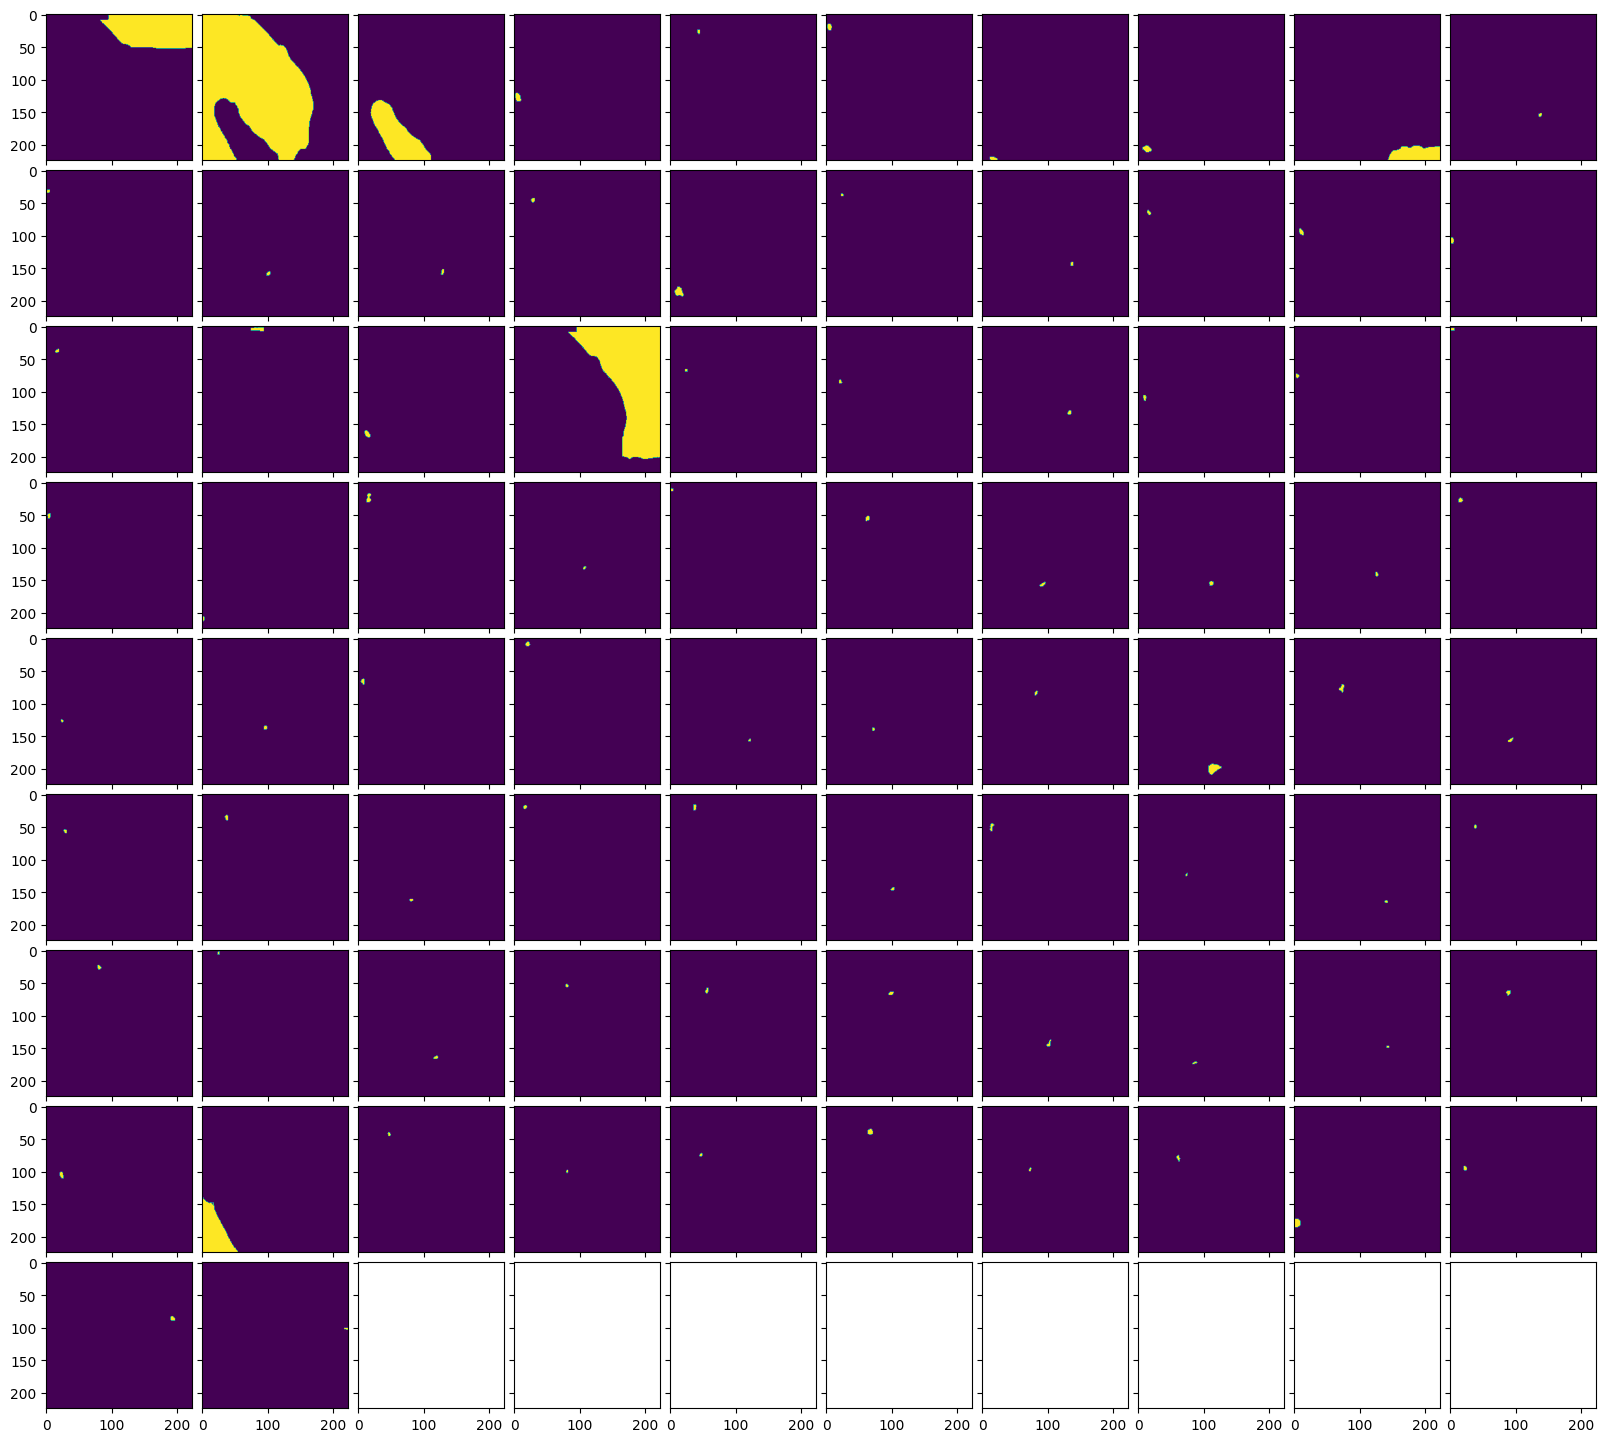

In [13]:
input_path = './results/leopard2/leopard2_input.jpg'
save_masks = get_mask(input_path)

In [14]:
mask_nb = 1
total_gradcams = 3
list_of_gradcams = []
for i in range(total_gradcams):
  list_of_gradcams.append('/'.join(input_path.split('/')[:-1]) + '/' + 'g_' + '_'.join(input_path.split('/')[-1].split('_')[:-1]) + '_gradcam_desc_{}.jpg'.format(i))
compute_core_spurious(mask_nb, list_of_gradcams, save_masks)

Core %     description_0: 0.5282804751183822
Spurious % description_0: 0.4717195248816177
Core %     description_1: 0.5153683472170828
Spurious % description_1: 0.4846316527829172
Core %     description_2: 0.5386878254626972
Spurious % description_2: 0.4613121745373027


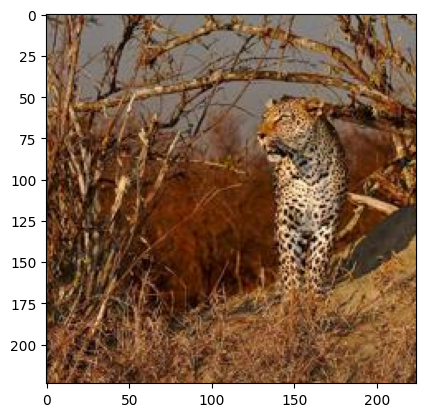

<Figure size 640x480 with 0 Axes>

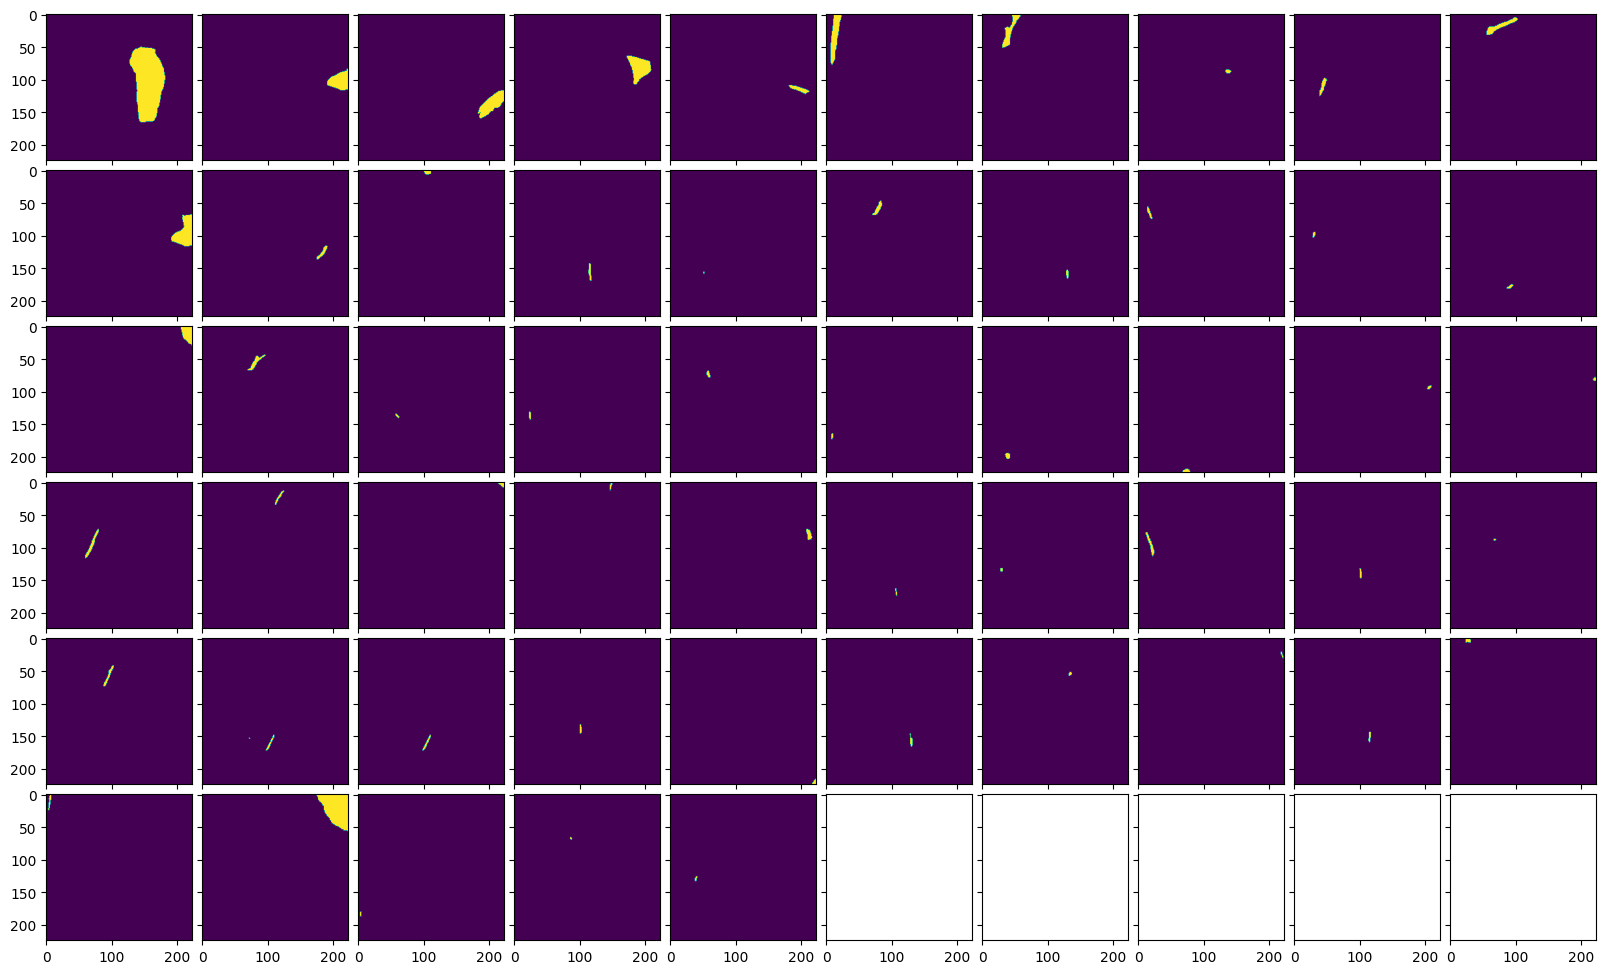

In [15]:
input_path = './results/leopard3/leopard3_input.jpg'
save_masks = get_mask(input_path)

In [16]:
mask_nb = 0
total_gradcams = 3
list_of_gradcams = []
for i in range(total_gradcams):
  list_of_gradcams.append('/'.join(input_path.split('/')[:-1]) + '/' + 'g_' + '_'.join(input_path.split('/')[-1].split('_')[:-1]) + '_gradcam_desc_{}.jpg'.format(i))
compute_core_spurious(mask_nb, list_of_gradcams, save_masks)

Core %     description_0: 0.5938826221918316
Spurious % description_0: 0.40611737780816837
Core %     description_1: 0.49062941064647725
Spurious % description_1: 0.5093705893535229
Core %     description_2: 0.7567777795576008
Spurious % description_2: 0.2432222204423991


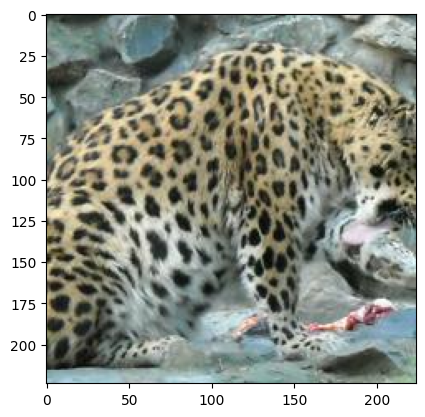

<Figure size 640x480 with 0 Axes>

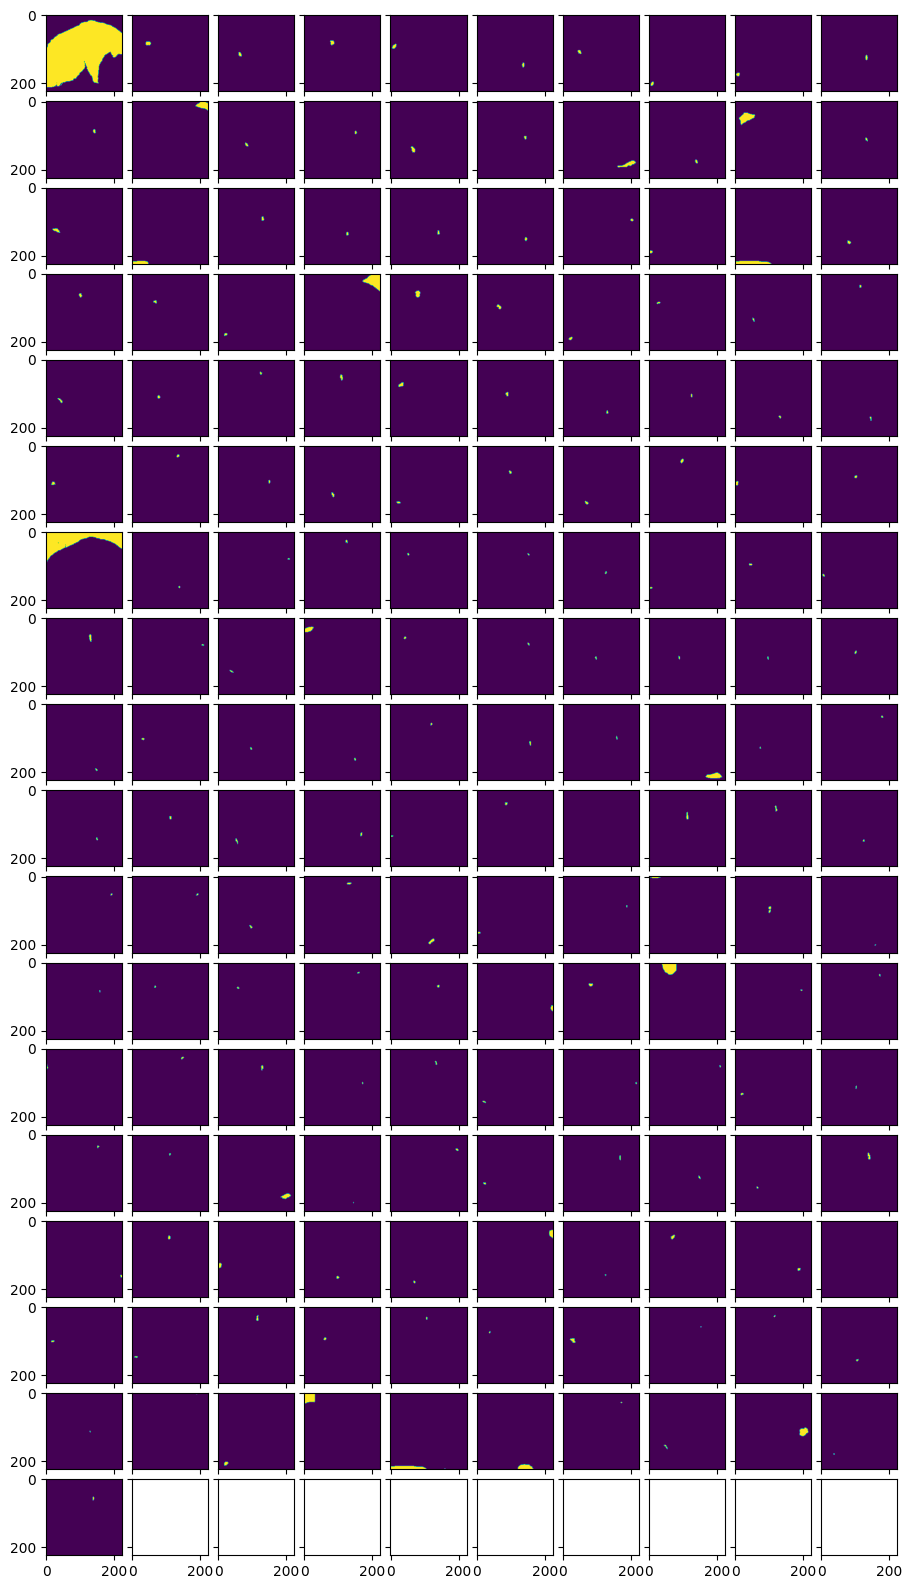

In [17]:
input_path = './results/leopard4/leopard4_input.jpg'
save_masks = get_mask(input_path)

In [18]:
mask_nb = 0
total_gradcams = 3
list_of_gradcams = []
for i in range(total_gradcams):
  list_of_gradcams.append('/'.join(input_path.split('/')[:-1]) + '/' + 'g_' + '_'.join(input_path.split('/')[-1].split('_')[:-1]) + '_gradcam_desc_{}.jpg'.format(i))
compute_core_spurious(mask_nb, list_of_gradcams, save_masks)

Core %     description_0: 0.21862317551857904
Spurious % description_0: 0.781376824481421
Core %     description_1: 0.4255373004457435
Spurious % description_1: 0.5744626995542564
Core %     description_2: 0.48167800116275505
Spurious % description_2: 0.5183219988372451


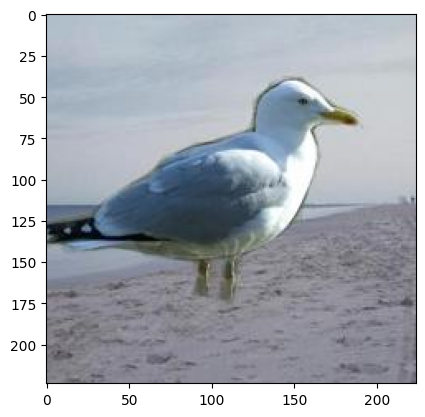

<Figure size 640x480 with 0 Axes>

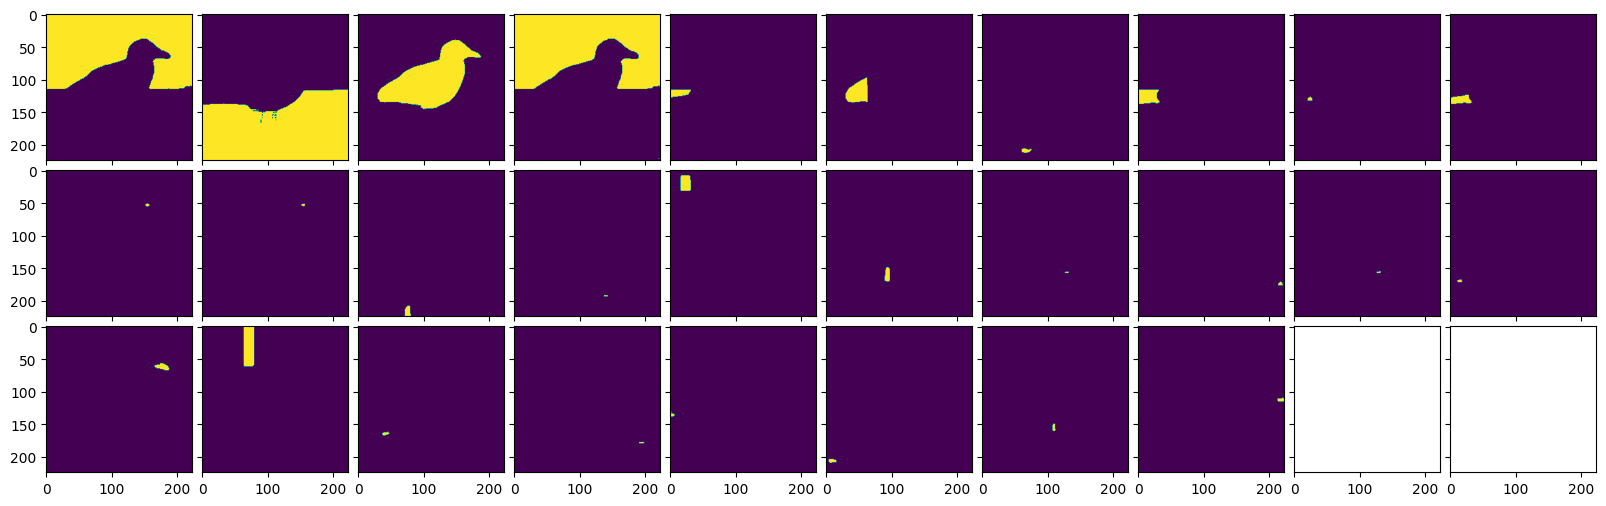

In [19]:
input_path = './results/waterbird1/waterbird1_input.jpg'
save_masks = get_mask(input_path)

In [20]:
mask_nb = 2
total_gradcams = 3
list_of_gradcams = []
for i in range(total_gradcams):
  list_of_gradcams.append('/'.join(input_path.split('/')[:-1]) + '/' + 'g_' + '_'.join(input_path.split('/')[-1].split('_')[:-1]) + '_gradcam_desc_{}.jpg'.format(i))
compute_core_spurious(mask_nb, list_of_gradcams, save_masks)

Core %     description_0: 0.5656665205212629
Spurious % description_0: 0.43433347947873713
Core %     description_1: 0.5276802435618213
Spurious % description_1: 0.47231975643817864
Core %     description_2: 0.6006841021251048
Spurious % description_2: 0.3993158978748952


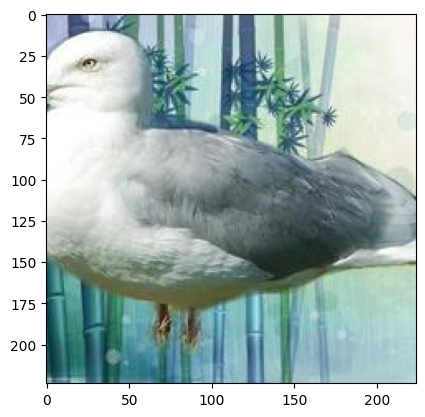

<Figure size 640x480 with 0 Axes>

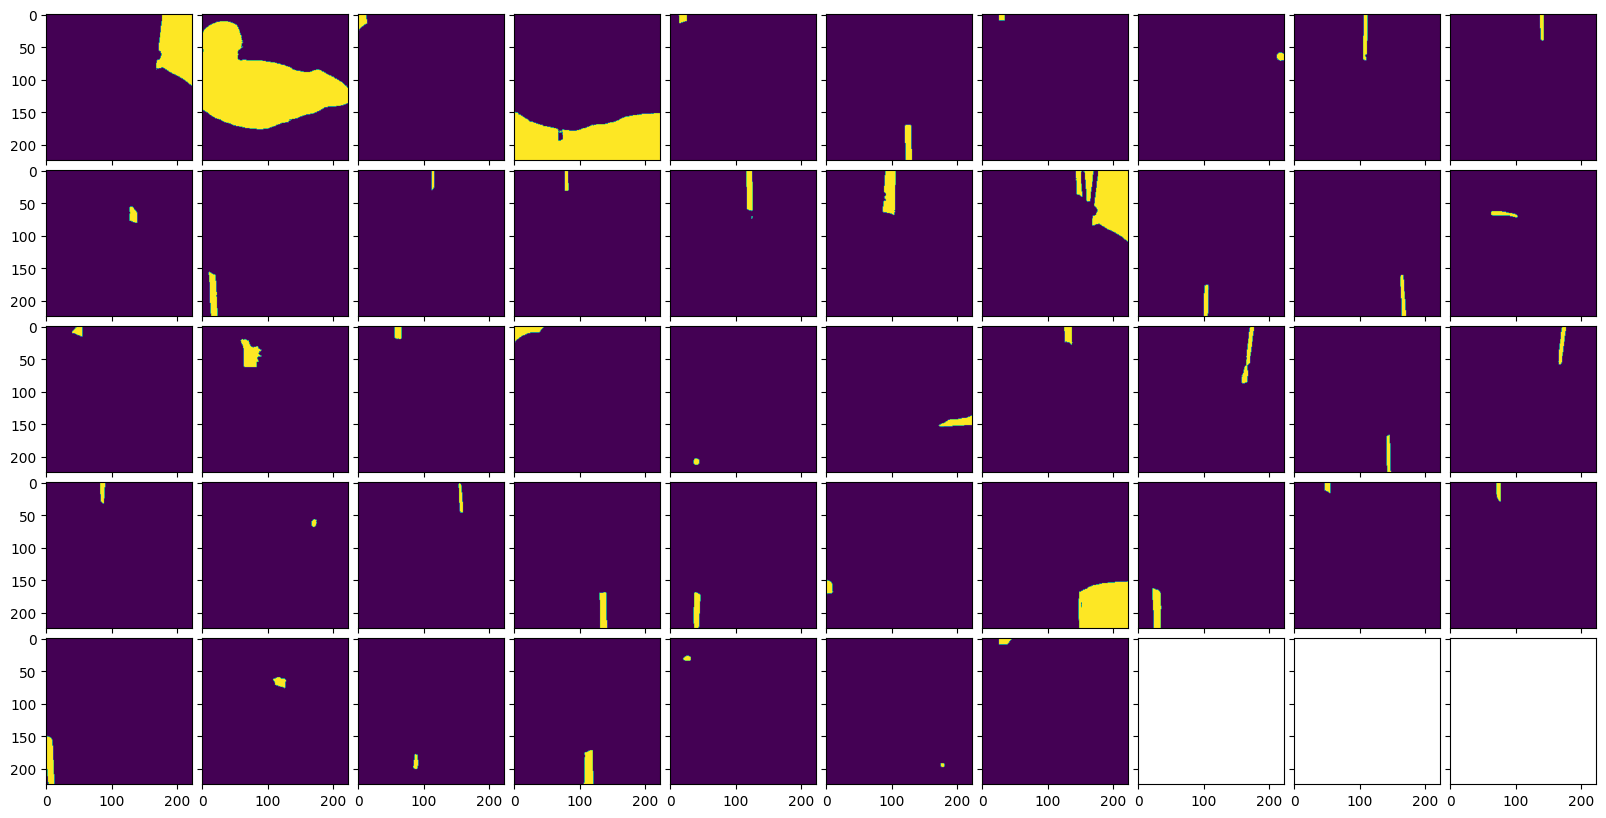

In [21]:
input_path = './results/waterbird2/waterbird2_input.jpg'
save_masks = get_mask(input_path)

In [22]:
mask_nb = 1
total_gradcams = 3
list_of_gradcams = []
for i in range(total_gradcams):
  list_of_gradcams.append('/'.join(input_path.split('/')[:-1]) + '/' + 'g_' + '_'.join(input_path.split('/')[-1].split('_')[:-1]) + '_gradcam_desc_{}.jpg'.format(i))
compute_core_spurious(mask_nb, list_of_gradcams, save_masks)

Core %     description_0: 0.5410528003810677
Spurious % description_0: 0.4589471996189322
Core %     description_1: 0.48537074464282204
Spurious % description_1: 0.514629255357178
Core %     description_2: 0.6683861516290871
Spurious % description_2: 0.3316138483709128


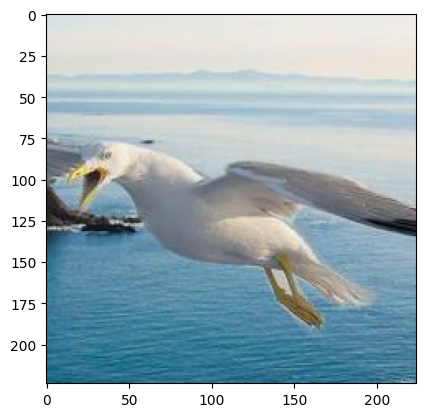

<Figure size 640x480 with 0 Axes>

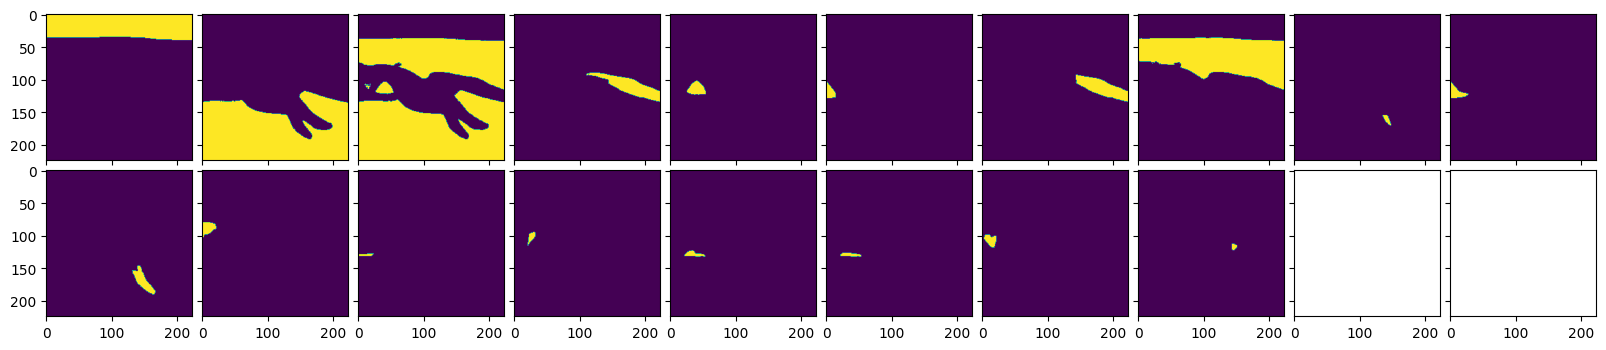

In [23]:
input_path = './results/waterbird3/waterbird3_input.jpg'
save_masks = get_mask(input_path)

Core %     description_0: 0.4642391006755072
Spurious % description_0: 0.5357608993244927
Core %     description_1: 0.4099399370067328
Spurious % description_1: 0.5900600629932672
Core %     description_2: 0.6491116411966081
Spurious % description_2: 0.35088835880339186


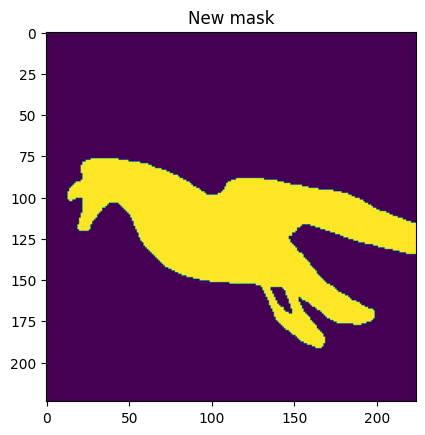

In [24]:
mask_nb = None
custom_mask = 'waterbird3'
total_gradcams = 3
list_of_gradcams = []
for i in range(total_gradcams):
  list_of_gradcams.append('/'.join(input_path.split('/')[:-1]) + '/' + 'g_' + '_'.join(input_path.split('/')[-1].split('_')[:-1]) + '_gradcam_desc_{}.jpg'.format(i))
compute_core_spurious(mask_nb, list_of_gradcams, save_masks, custom_mask)

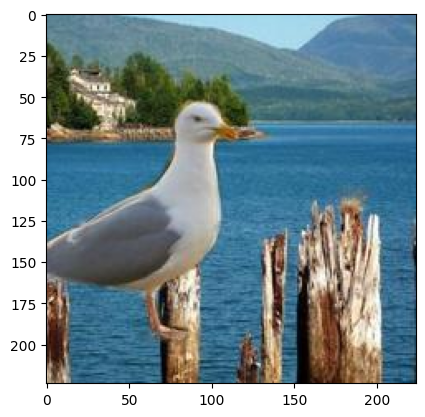

<Figure size 640x480 with 0 Axes>

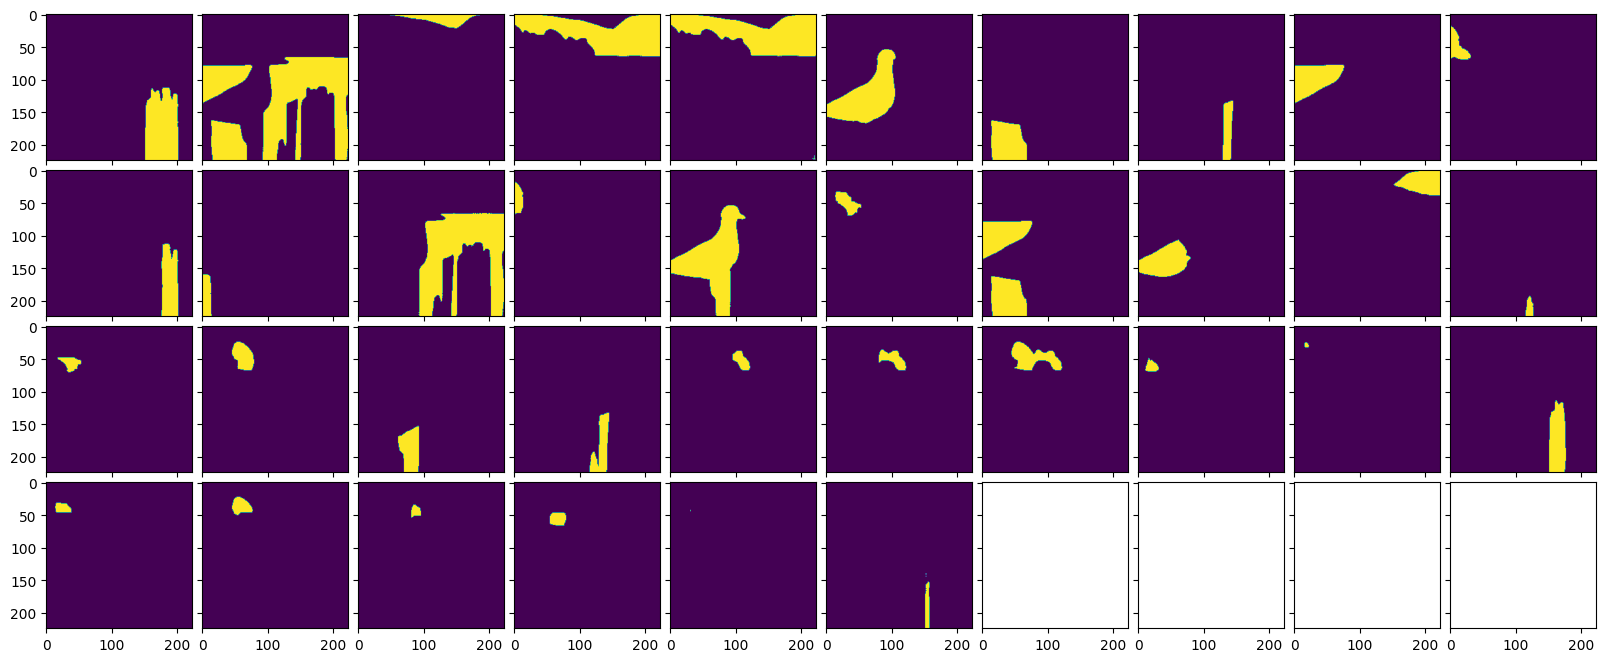

In [25]:
input_path = './results/waterbird4/waterbird4_input.jpg'
save_masks = get_mask(input_path)

In [26]:
mask_nb = 14
total_gradcams = 3
list_of_gradcams = []
for i in range(total_gradcams):
  list_of_gradcams.append('/'.join(input_path.split('/')[:-1]) + '/' + 'g_' + '_'.join(input_path.split('/')[-1].split('_')[:-1]) + '_gradcam_desc_{}.jpg'.format(i))
compute_core_spurious(mask_nb, list_of_gradcams, save_masks)

Core %     description_0: 0.5575125864466196
Spurious % description_0: 0.44248741355338045
Core %     description_1: 0.4927387096549019
Spurious % description_1: 0.507261290345098
Core %     description_2: 0.6751076220045025
Spurious % description_2: 0.3248923779954976
